In [1]:
import os


import torch as th
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.transforms as T

import albumentations as A

from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import open_clip
from PIL import Image
import faiss

import matplotlib.pyplot as plt

import utilities

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# get product 10k

def read_img(img_path, is_gray=False):
    mode = cv2.IMREAD_COLOR if not is_gray else cv2.IMREAD_GRAYSCALE
    img = cv2.imread(img_path, mode)
    if not is_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

class ProductDataset(Dataset):
    def __init__(self, 
                 img_dir, 
                 annotations_file, 
                 transform=None, 
                 final_transform=None, 
                 headers=None,
                 sep=',',
                 test_mode=False,
                 g):
        self.data = pd.read_csv(annotations_file, sep=sep)
        self.img_dir = img_dir
        self.transform = transform
        self.final_transform = final_transform
        self.headers = {"img_path": "img_path", "product_id": "product_id"}
        if headers:
            self.headers = headers
        self.test_mode = test_mode
            
    def __len__(self):
        return len(self.data) // 5000
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data[self.headers["img_path"]][idx])
        
        img = read_img(img_path)
        if self.test_mode:
            x, y, w, h = self.data["bbox_x"][idx], self.data["bbox_y"][idx], \
                         self.data["bbox_w"][idx], self.data["bbox_h"][idx]
            img = img[y:y+h, x:x+w]
            
        
        if self.transform is not None:
            img = transform(image=img)["image"]
        
        if self.final_transform is not None:
            if isinstance(img, np.ndarray):
                img =  Image.fromarray(img)
            img = self.final_transform(img)
            
        meta_data = {
            "product_id": self.data[self.headers["product_id"]][idx],
            "img_path":  self.data[self.headers["img_path"]][idx]
        }
        return img, meta_data
    
def get_final_transform():  
    final_transform = T.Compose([
            T.Resize(
                size=(224, 224), 
                interpolation=T.InterpolationMode.BICUBIC,
                antialias=True),
            T.ToTensor(), 
            T.Normalize(
                mean=(0.48145466, 0.4578275, 0.40821073), 
                std=(0.26862954, 0.26130258, 0.27577711)
            )
        ])
    return final_transform


In [3]:
vit_backbone, _, _ = open_clip.create_model_and_transforms(
    'ViT-H-14', pretrained=None
)

model = vit_backbone.visual
model.load_state_dict(th.load('my_experiments/ViT-H-14-laion2b_s32b_b79k-image_net-v2-p10k-h&m-shopee-sop-Arcface(k=3)-Epoch(10)-Focal-Loss/model_epoch_2_mAP3_0.57_slim_f16.pt'))
model.half()
model.eval()
model.cuda()
print()

In [4]:
from sklearn.preprocessing import normalize

@th.no_grad()
def extract_embeddings(model, dataloader, epoch=10, use_cuda=True):
    features = []
    meta_data = []
    
    for _ in range(epoch):
        for imgs, meta in tqdm(dataloader):
            if use_cuda:
                imgs = imgs.cuda()
            features.append(th.squeeze(model(imgs.half())).detach().cpu().numpy().astype(np.float32))
            meta_data.append(meta)
    
    # to lazy to fix it so workaround
    img_path = []
    for m in meta_data:
        img_path.extend(m['img_path'])
        
    product_id = th.concat(tuple(m['product_id'] for m in meta_data)).detach().cpu().numpy()
    

    return np.concatenate(features, axis=0), img_path, product_id

def calculate_map_scores(product_id_test, product_id_train, ind):
    map_score_per_image = []

    for i, product_id in enumerate(tqdm(product_id_test)): 
        loc_ = np.where(product_id_train[ind[i]] == product_id_test[i])[0]
        if len(loc_) > 0:
            map_score_per_image.append(
                np.sum(
                    np.arange(1, len(loc_[:3]) + 1) / (loc_[:3]+1)
                ) / 3)
        else:
            map_score_per_image.append(0)

    map_score_per_image = np.array(map_score_per_image)
    print(f"Mean AP@3 is {np.mean(map_score_per_image)}")
    worst_to_best = np.argsort(map_score_per_image)
    return worst_to_best, map_score_per_image

def plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_q, 
             product_id_g, 
             distances,
             map_score
            ):
    imgs = [read_img(os.path.join(img_dir, img_path_q))]
    imgs.extend([read_img(os.path.join(img_dir, img_path)) for img_path in img_path_g])
    
    fig = plt.figure(figsize=(26, 4))
    for i in range(len(imgs)):
        img = imgs[i]
        fig.add_subplot(1, len(imgs) + 1, i+1)
        if i == 0:
            title = f'Product ({product_id_q})\nP@3({map_score:.2f})'
        else:
            title = f'''Product ({product_id_g[i-1]})\nDist({distances[i-1]:.2f})'''
        plt.title(title, fontsize=10)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

## Test DATA

In [13]:
final_transform = get_final_transform()
img_dir = "../development_test_data"

dataset_test = ProductDataset(img_dir, os.path.join(img_dir, "queries.csv"), None, final_transform, test_mode=True)
dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4)

features_test, img_path_test, product_id_test = extract_embeddings(model, dataloader_test, 1)

dataset_train = ProductDataset(img_dir, os.path.join(img_dir, "gallery.csv"), None, final_transform)
dataloader_train = DataLoader(dataset_train, batch_size=512, num_workers=4)

features_train, img_path_train, product_id_train = extract_embeddings(model, dataloader_train, 1)

100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.93s/it]


In [14]:
product_10k_features = np.concatenate([features_train, features_test], axis=0)
product_10k_features.shape

(3002, 1024)

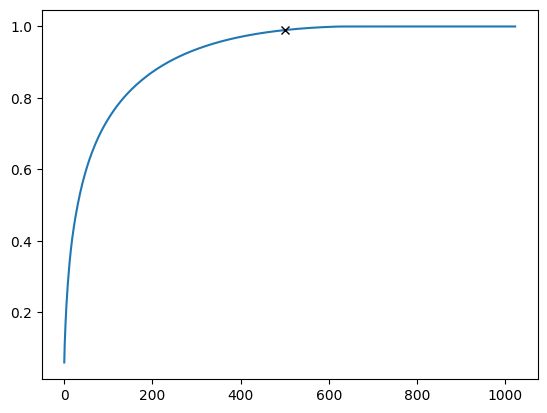

In [15]:
# do PCA
import sklearn.decomposition as D
import pickle

# transform data
pca = D.PCA().fit(product_10k_features)
var_sum = np.cumsum(pca.explained_variance_ratio_)
idx = np.where(var_sum > 0.99)[0][0]

pca_path = 'my_experiments/ViT-L-14-laion2b_s32b_b82k-image_net-v2-product-10k-ArcFace(k=3)-All/pca_epoch_4.pkl'
pca_ = D.PCA(idx).fit(product_10k_features)
with open(pca_path, 'wb') as f:
    pickle.dump(pca_, f)

plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), '-')
plt.plot(idx, var_sum[idx], 'xk')

In [ ]:
features_test = pca_.transform(features_test)
features_train = pca_.transform(features_train)

In [16]:
dist, ind = utilities.get_similiarity_l2(features_train, features_test, 10000)

Processing indices...
Finished processing indices, took 0.308901309967041s


In [17]:
worst_to_best, map_score_per_image = calculate_map_scores(product_id_test, product_id_train, ind)

100%|██████████████████████████████████████████████████████████████████████████████| 1935/1935 [00:00<00:00, 57171.28it/s]

Mean AP@3 is 0.3382549757405138


785 predictions [4969 4969 5053 5294 5294 4991 5168 5074 5258 5092 5242 5242 5051 5269
 5316] truth 4996


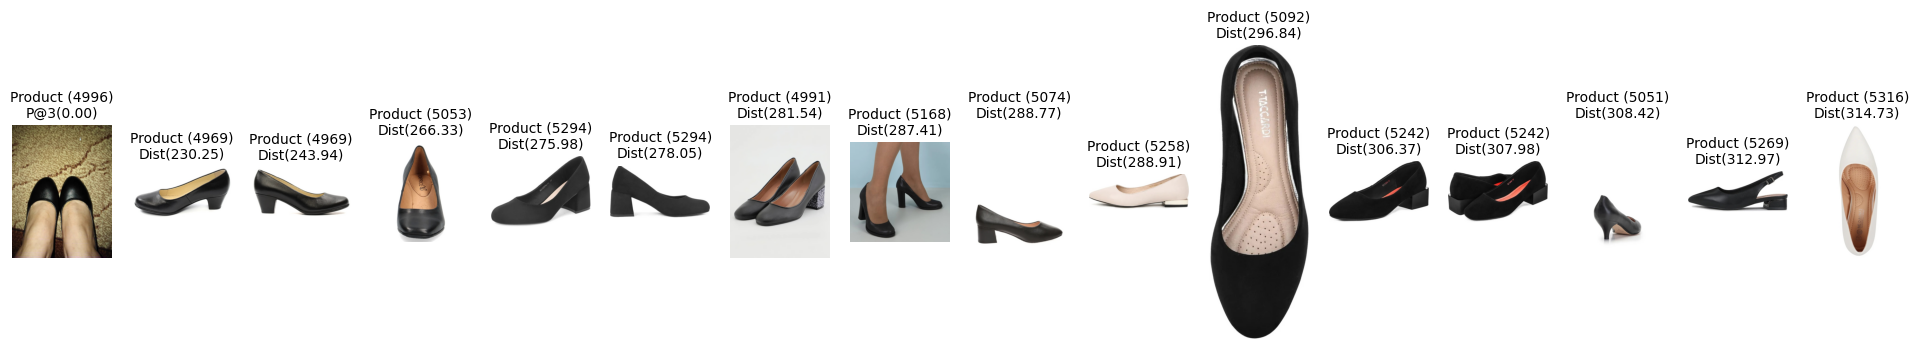

147 predictions [5030 4971 5303 5232 5250 5034 5232 5284 5250 5303 5250 5294 5326 5205
 5110] truth 5145


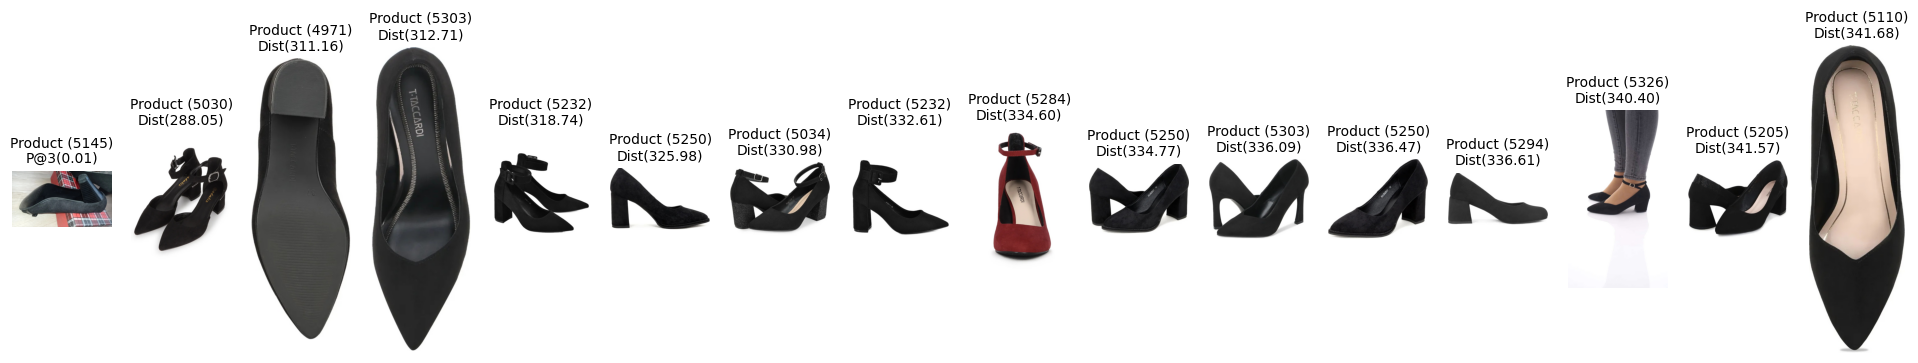

1037 predictions [3562 3669 3614 3692 3571 3551 3601 3679 3570 3700 3705 3601 3462 3705
 3669] truth 3617


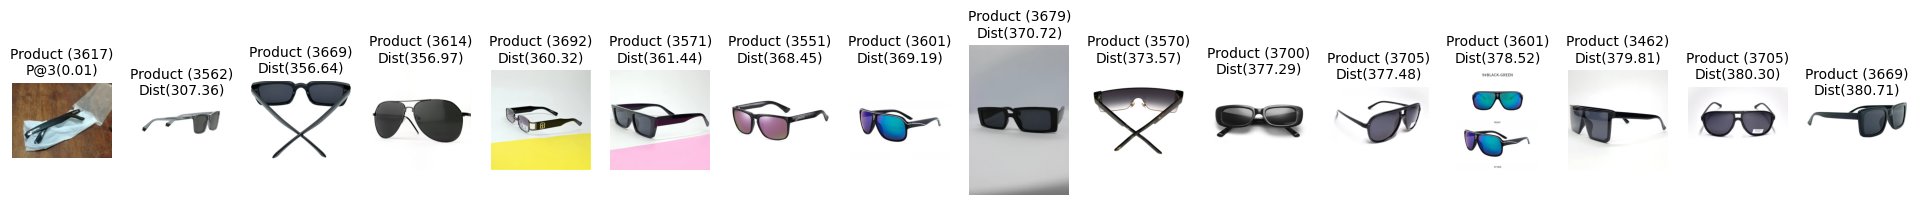

1343 predictions [5279 5291 5349 5319 5296 5159 5070 5111 5279 5159 5196 5078 5296 5103
 5340] truth 5347


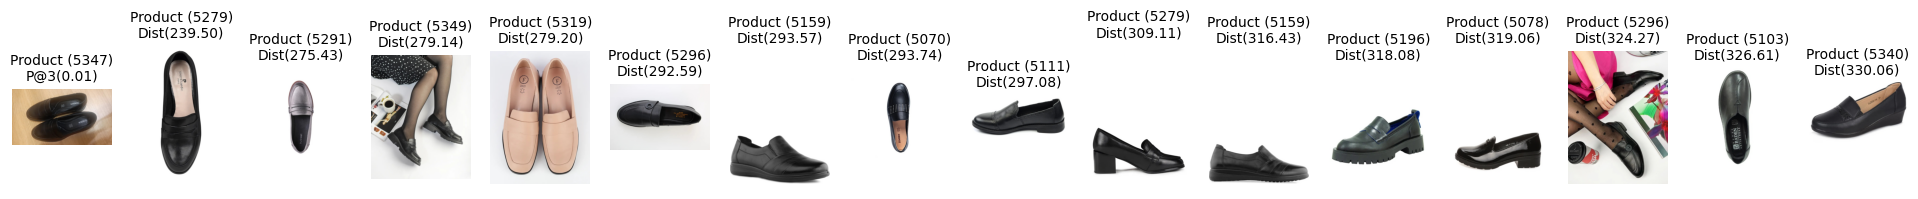

1441 predictions [3610 3516 3652 3480 3652 3603 3487 3501 3483 3542 3516 3657 3464 3464
 3483] truth 3539


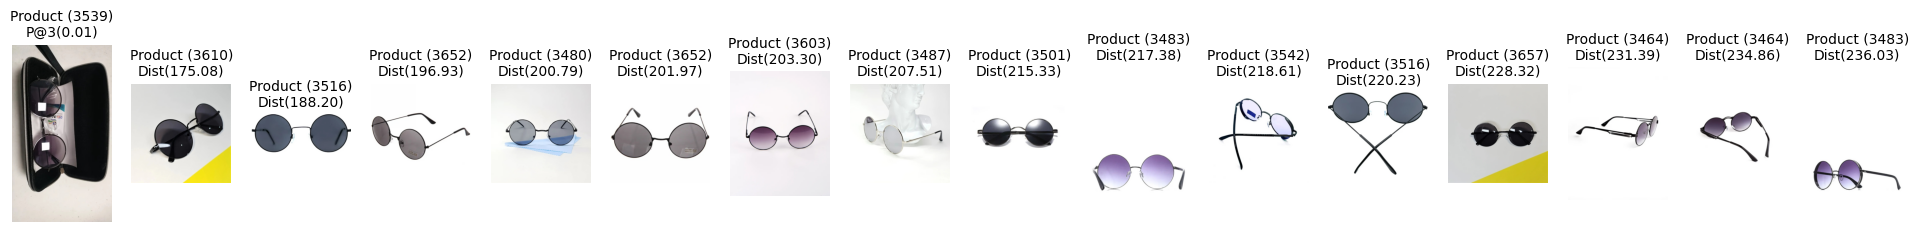

1490 predictions [4969 4969 5053 5258 5074 4964 4991 5342 5168 5165 5294 5140 5103 5294
 5242] truth 4996


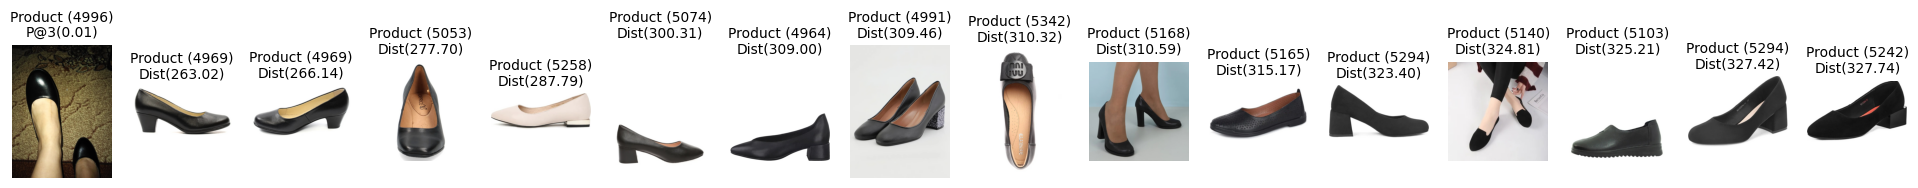

138 predictions [3462 3527 3571 3569 3555 3540 3510 3641 3647 3669 3461 3552 3641 3570
 3555] truth 3619


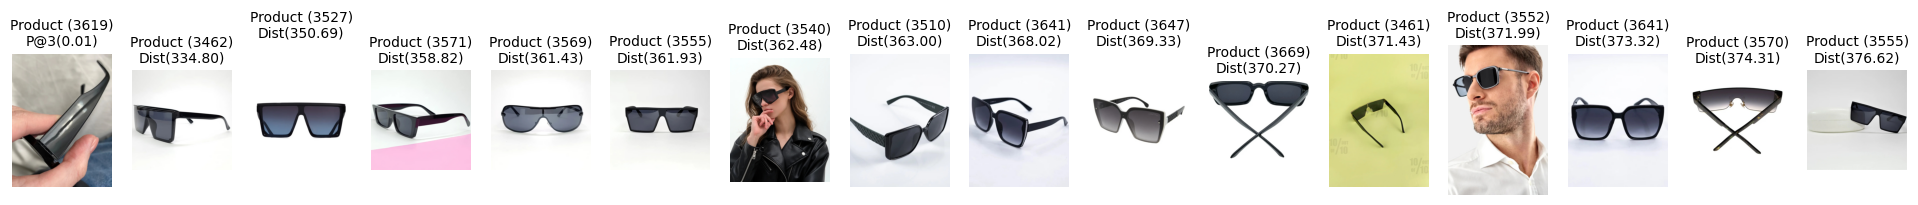

1752 predictions [5349 5296 5196 5279 5196 5296 5291 5073 5196 5078 5073 5103 5279 5078
 5319] truth 5347


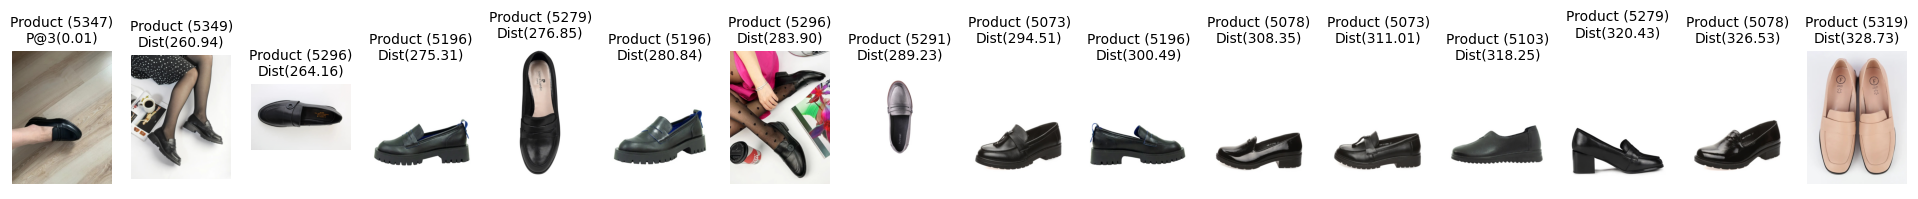

1197 predictions [5110 5154 5154 5154 5303 5295 5337 5295 5020 5292 4981 5303 4971 5210
 5030] truth 5264


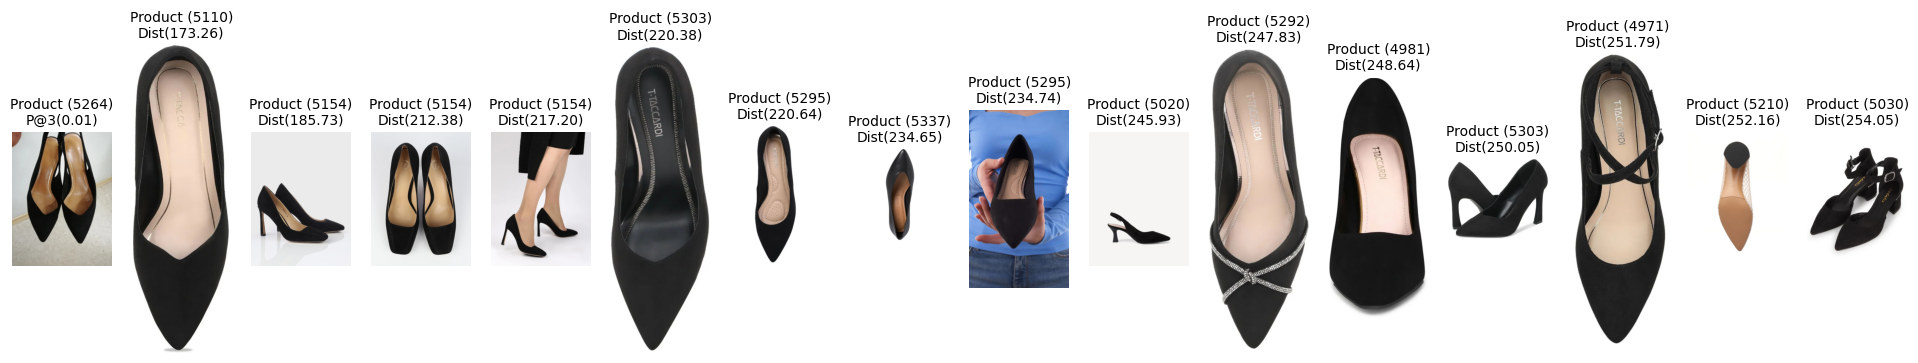

261 predictions [3468 3520 3622 3488 3468 3702 3702 3559 3572 3615 3615 3651 3468 3572
 3624] truth 3459


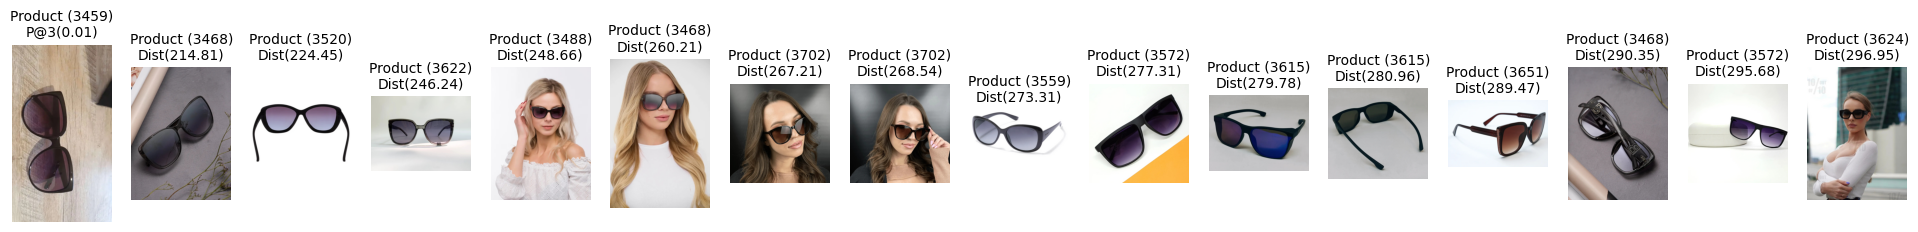

In [22]:
for i in worst_to_best[70:80]:
    idx_ = ind[i][:15]
    
    print(i, 'predictions', product_id_train[idx_], 'truth', product_id_test[i])
    img_path_q = img_path_test[i]
    img_path_g = [img_path_train[j] for j in idx_]
    plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_test[i], 
             product_id_train[idx_], 
             dist[i],
             map_score_per_image[i])

34 predictions [3541 3541 3541 3511 3627 3511 3627 3627 3663 3634 3616 3514 3485 3490
 3558] truth 3541


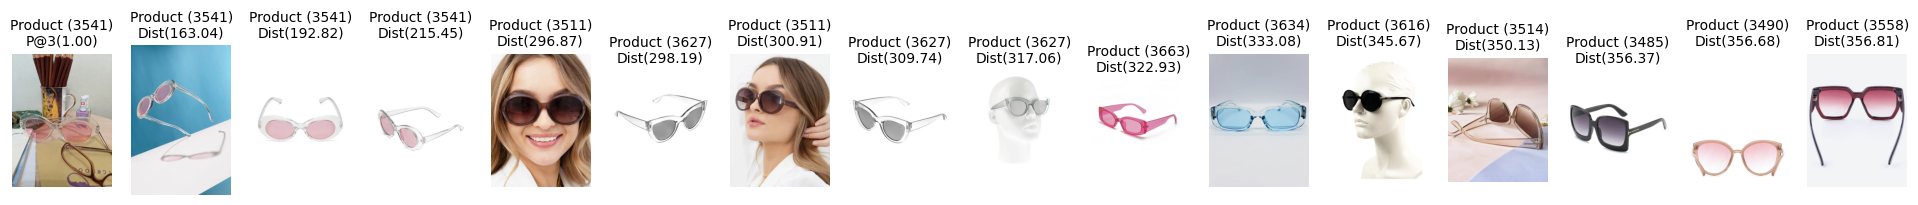

1580 predictions [5101 5101 5101 5101 5009 5148 5329 5009 5201 5082 5082 5210 5129 5201
 5329] truth 5101


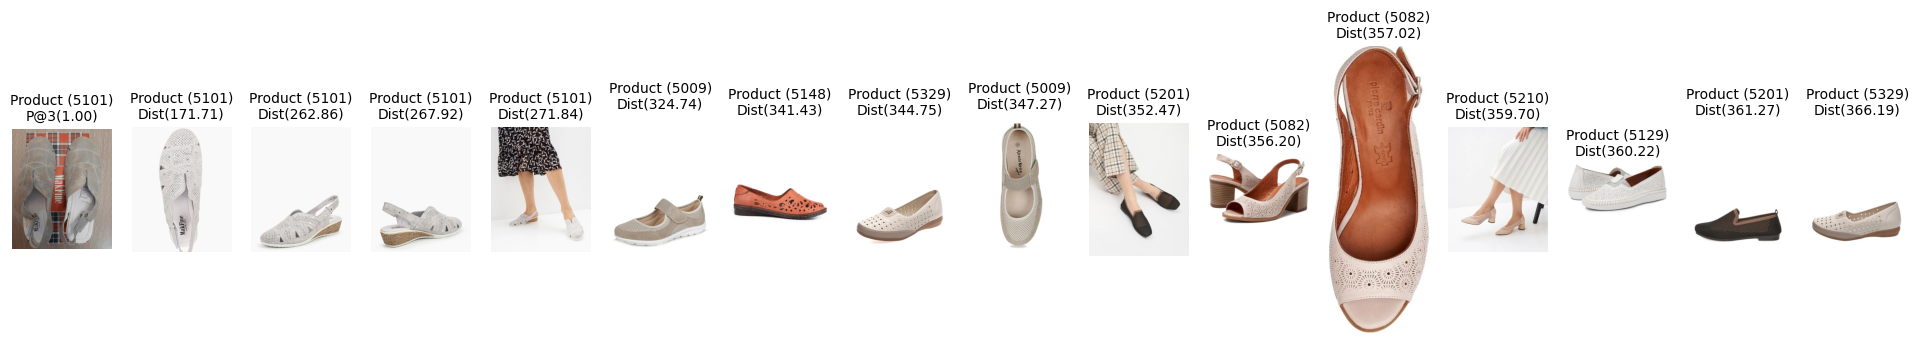

1426 predictions [5082 5082 5082 5188 5043 5085 5014 4968 5324 5084 4975 5085 5043 5043
 5101] truth 5082


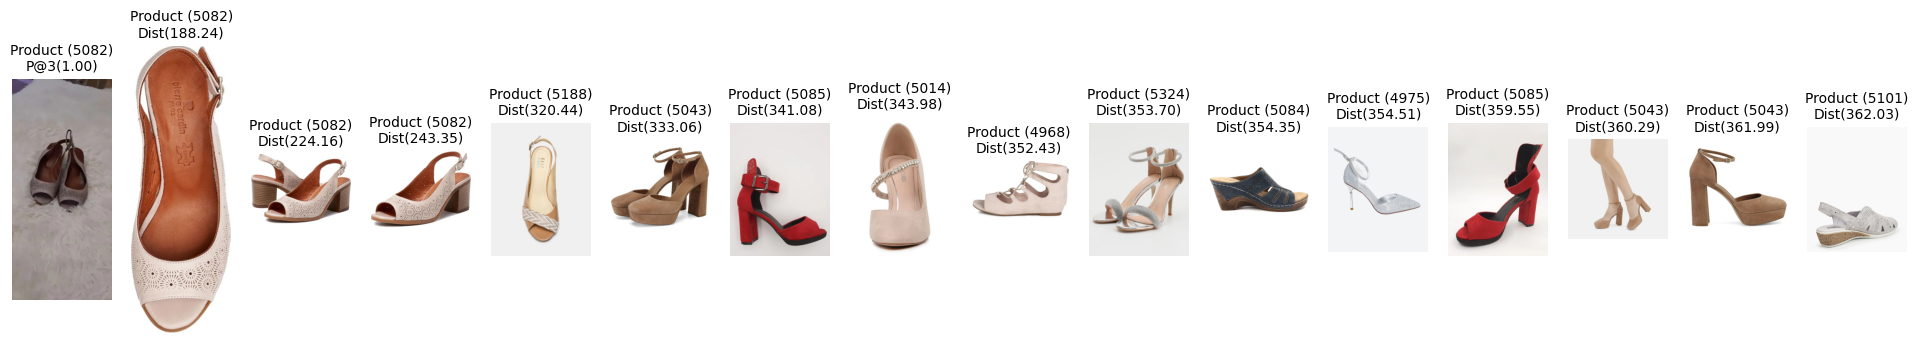

1428 predictions [5353 5353 5353 4948 5263 5321 5263 5323 5323 5130 5268 5108 5321 5131
 5081] truth 5353


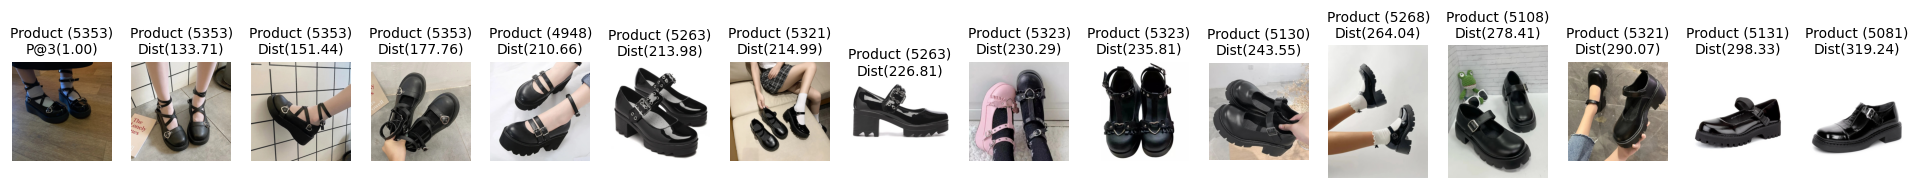

1365 predictions [5176 5176 5176 5186 5253 5096 5253 5197 5197 5197 3704 3487 3701 3704
 3644] truth 5176


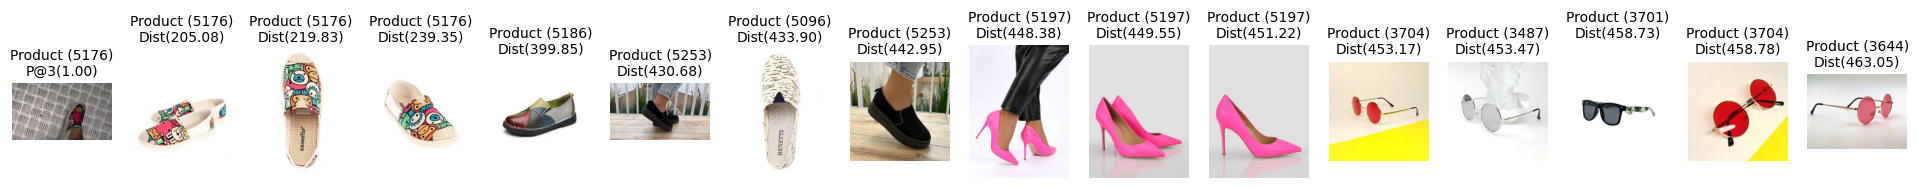

1434 predictions [5176 5176 5176 5186 5096 5253 5140 5059 5253 5140 5226 5140 5059 5226
 5160] truth 5176


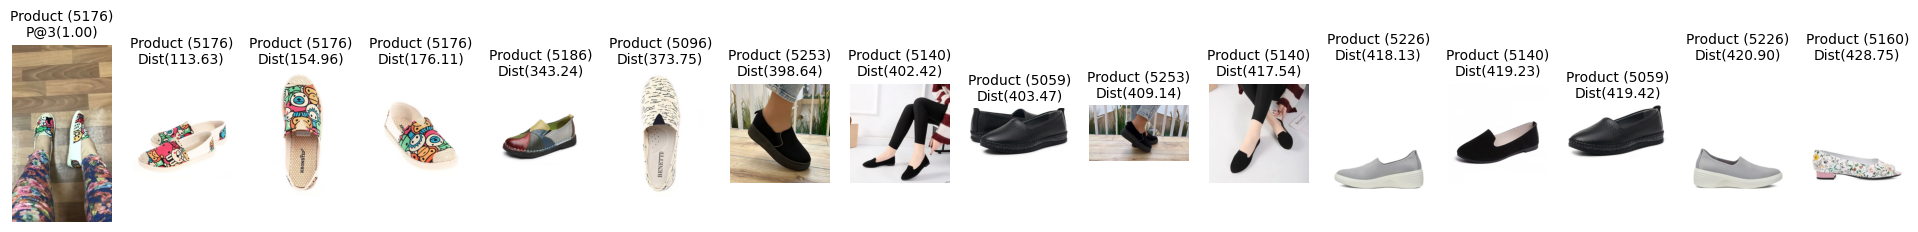

1533 predictions [5073 5073 5073 5073 5108 5297 5321 5335 5131 5130 5297 5335 5297 5345
 5321] truth 5073


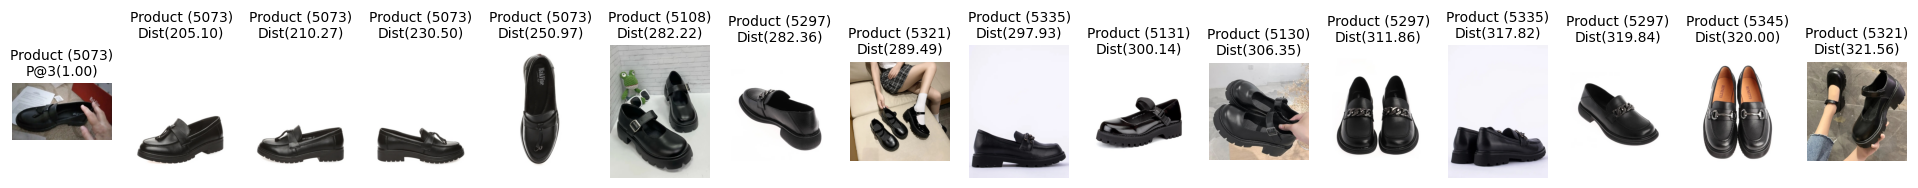

1538 predictions [5185 5185 5185 5291 4958 5143 5144 5349 5144 5291 5319 5008 5223 5296
 5274] truth 5185


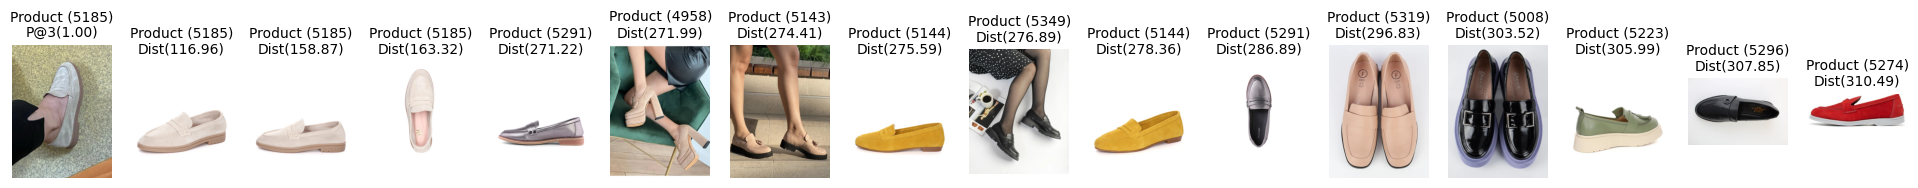

12 predictions [5143 5143 5143 5218 5223 5036 5223 5081 5268 5102 5263 5263 5185 5102
 5321] truth 5143


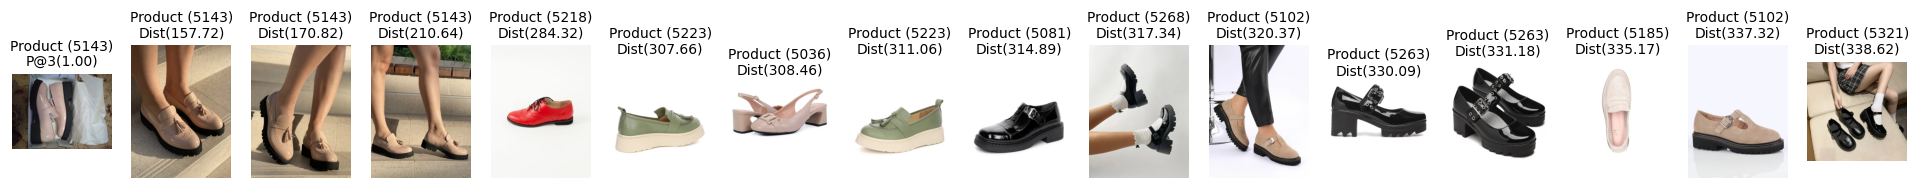

10 predictions [5008 5008 5008 5008 5008 5297 5196 5196 5297 5268 5196 5297 5321 5335
 5223] truth 5008


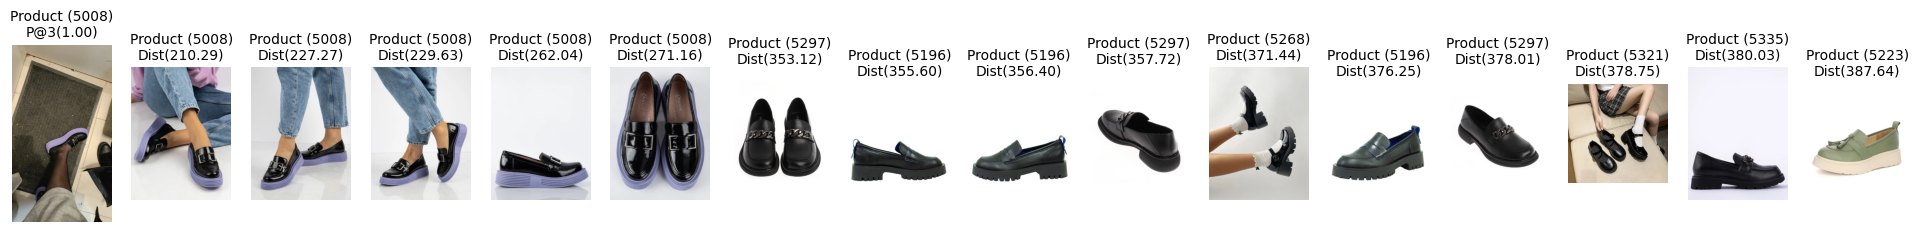

In [19]:
for i in worst_to_best[-100:-90]:
    idx_ = ind[i][:15]
    
    print(i, 'predictions', product_id_train[idx_], 'truth', product_id_test[i])
    img_path_q = img_path_test[i]
    img_path_g = [img_path_train[j] for j in idx_]
    plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_test[i], 
             product_id_train[idx_], 
             dist[i],
             map_score_per_image[i])

## SOP

In [11]:
img_dir = "../Stanford_Online_Products"

In [12]:
final_transform = get_final_transform()

dataset_shopee = ProductDataset(img_dir, 
                              '../Stanford_Online_Products/Ebay_test.txt', 
                              None, 
                              final_transform, 
                              sep = ' ',
                              headers = {"img_path": "path", "product_id": "class_id"})
dataloader_shopee = DataLoader(dataset_shopee, batch_size=512, num_workers=4)

features_shopee, img_path_shopee, product_id_shopee = extract_embeddings(model, dataloader_shopee, 1)



 39%|████████████████████████████████▍                                                   | 46/119 [02:37<04:07,  3.39s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f36e0caff70>
Traceback (most recent call last):
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/multiprocessing/connecti

KeyboardInterrupt: 

In [ ]:
dist_shopee, ind_shopee = utilities.get_similiarity_hnsw(features_shopee, features_shopee, 16)
worst_to_best_shopee, map_score_per_image_shopee = calculate_map_scores(
    product_id_shopee, 
    product_id_shopee, 
    ind_shopee
)

In [ ]:
for i in worst_to_best_shopee[10:20]:
    idx_ = ind_shopee[i][1:]
    
    print(i, 'predictions', product_id_shopee[idx_], 'truth', product_id_shopee[i])
    img_path_q = img_path_shopee[i]
    img_path_g = [img_path_shopee[j] for j in idx_]
    plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_shopee[i], 
             product_id_shopee[idx_], 
             dist_shopee[i][1:],
             map_score_per_image_shopee[i])

In [ ]:
for i in worst_to_best_shopee[-120:-110]:
    idx_ = ind_shopee[i][1:]
    
    print(i, 'predictions', product_id_shopee[idx_], 'truth', product_id_shopee[i])
    img_path_q = img_path_shopee[i]
    img_path_g = [img_path_shopee[j] for j in idx_]
    plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_shopee[i], 
             product_id_shopee[idx_], 
             dist_shopee[i][1:],
             map_score_per_image_shopee[i])

## Shoppe

In [7]:
img_dir = "../shopee/train_images"

In [8]:
final_transform = get_final_transform()

dataset_shopee = ProductDataset(img_dir, 
                              '../shopee/train.csv', 
                              None, 
                              final_transform, 
                              headers = {"img_path": "image", "product_id": "label_group"})
dataloader_shopee = DataLoader(dataset_shopee, batch_size=512, num_workers=4)